In [1]:
## importing libraries
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import string
from langdetect import detect, LangDetectException


/home/nyarrabolu_umass_edu/.conda/envs/legacy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Train Dataset Processing

In [2]:
## loading dataset
train_df = pd.read_csv("./raw/train.csv")
print(train_df)

                                                Context  \
0     I'm going through some things with my feelings...   
1     I'm going through some things with my feelings...   
2     I'm going through some things with my feelings...   
3     I'm going through some things with my feelings...   
4     I'm going through some things with my feelings...   
...                                                 ...   
3507  My grandson's step-mother sends him to school ...   
3508  My boyfriend is in recovery from drug addictio...   
3509  The birth mother attempted suicide several tim...   
3510  I think adult life is making him depressed and...   
3511  I just took a job that requires me to travel f...   

                                               Response  
0     If everyone thinks you're worthless, then mayb...  
1     Hello, and thank you for your question and see...  
2     First thing I'd suggest is getting the sleep y...  
3     Therapy is essential for those that are feelin...  
4

### Checking null values and duplicates

In [3]:
##checking null values 
print(train_df[['Context', 'Response']].isnull().sum())
train_df1 = train_df.dropna(subset=['Response'])
print(train_df1.shape)

Context     0
Response    4
dtype: int64
(3508, 2)


In [4]:
## dropping duplicates form both the columns 
train_df2 = train_df1.drop_duplicates(subset=['Context', 'Response'], keep='first')
print(train_df2.shape)

(2748, 2)


### Token & Word Count Distribution

/tmp/ipykernel_687903/1401309296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df2['word_count'] = train_df2['Response'].apply(lambda x: len(x.split()))


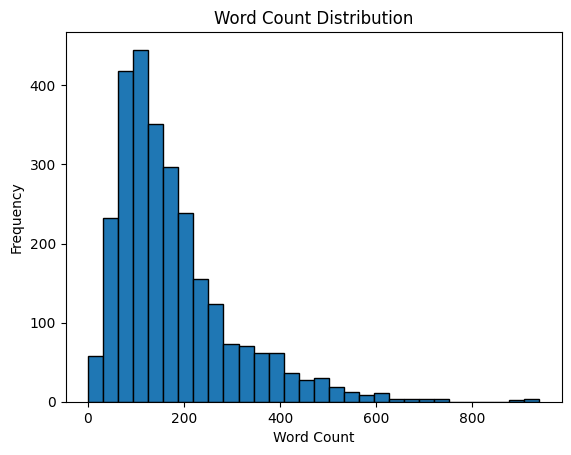

In [5]:
## word count distribution in response column
train_df2['word_count'] = train_df2['Response'].apply(lambda x: len(x.split()))
plt.hist(train_df2['word_count'], bins=30, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.show()

/tmp/ipykernel_687903/2905837944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df2['word_count'] = train_df2['Context'].apply(lambda x: len(x.split()))


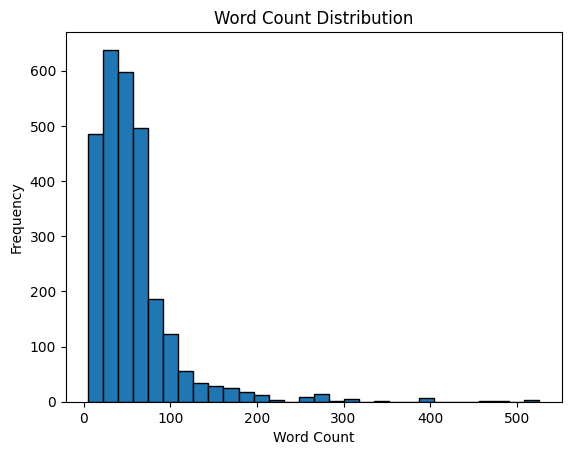

In [6]:
## word count distribution in context column
train_df2['word_count'] = train_df2['Context'].apply(lambda x: len(x.split()))
plt.hist(train_df2['word_count'], bins=30, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.show()

### from transformers import AutoTokenizer


/tmp/ipykernel_687903/1259617221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df2['token_count'] = train_df2['Response'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))


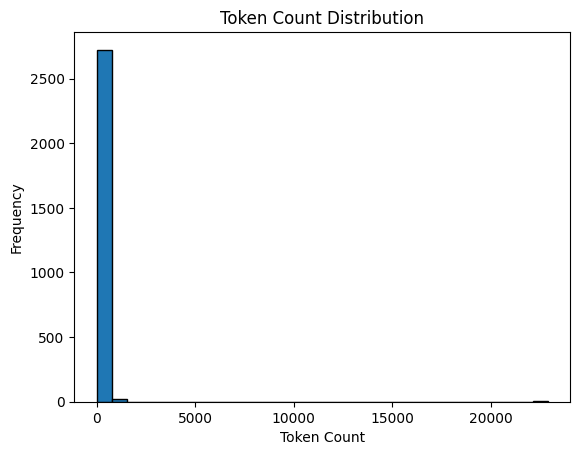

In [7]:
## tokens count distribution in Response Column
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")
train_df2['token_count'] = train_df2['Response'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))

plt.hist(train_df2['token_count'], bins=30, edgecolor='black')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Token Count Distribution')
plt.show()

/tmp/ipykernel_687903/4128016347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df2['token_count'] = train_df2['Context'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))


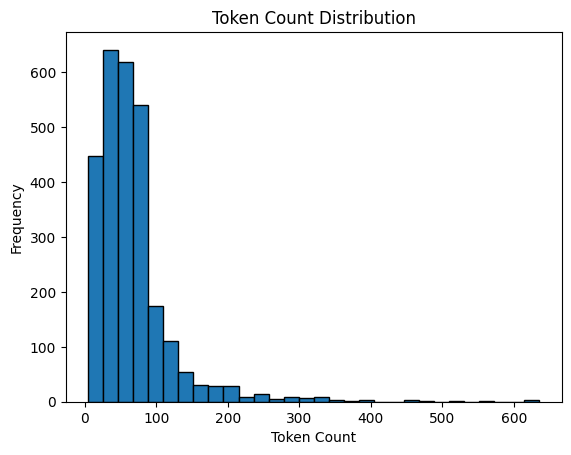

In [8]:
## tokens count distribution in context column
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")
train_df2['token_count'] = train_df2['Context'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))

plt.hist(train_df2['token_count'], bins=30, edgecolor='black')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Token Count Distribution')
plt.show()

### Checking Special Characters, Stopwords, & Punctuation

In [9]:
# Function to extract unique punctuation marks from a text
def get_unique_punctuations(text):
    return set(c for c in text if c in string.punctuation)

unique_punctuations = set()
train_df2['Response'].apply(lambda x: unique_punctuations.update(get_unique_punctuations(x)))
print("Unique punctuation marks in 'Context':", unique_punctuations)

unique_punctuations = set()
train_df2['Context'].apply(lambda x: unique_punctuations.update(get_unique_punctuations(x)))
print("Unique punctuation marks in 'Context':", unique_punctuations)

Unique punctuation marks in 'Context': {'~', '%', '#', '}', '(', '?', '@', '*', '=', ']', '_', '/', '!', ')', ',', '+', '-', '>', ';', '.', ':', '&', "'", '[', '{', '<', '"', '$'}
Unique punctuation marks in 'Context': {'%', '/', '!', '(', ')', ',', '?', '-', ';', '.', ':', "'", '"', '$', '*'}


### Checking for Non-English or Mixed Languages

In [10]:
# function to detect the language of text
def safe_detect(text):
    if not text or len(text.strip()) == 0:
        return 'unknown'  
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown' 

train_df2['language_response'] = train_df2['Response'].apply(safe_detect)
train_df2['language_context'] = train_df2['Context'].apply(safe_detect)
print(train_df2['language_response'].value_counts())
print(train_df2['language_context'].value_counts())


/tmp/ipykernel_687903/2008998116.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df2['language_response'] = train_df2['Response'].apply(safe_detect)


language_response
en         2697
es           50
unknown       1
Name: count, dtype: int64
language_context
en    2747
et       1
Name: count, dtype: int64


/tmp/ipykernel_687903/2008998116.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df2['language_context'] = train_df2['Context'].apply(safe_detect)


In [11]:
# Filter for rows where both language_response and language_context are 'en'
train_df2_filtered = train_df2[(train_df2['language_response'] == 'en') & (train_df2['language_context'] == 'en')]

# Print the shape of the filtered dataframe
print(train_df2.shape,train_df2_filtered.shape)
print(train_df2_filtered.columns)

(2748, 6) (2696, 6)
Index(['Context', 'Response', 'word_count', 'token_count', 'language_response',
       'language_context'],
      dtype='object')


In [12]:
train_df2_filtered = train_df2_filtered[['Context', 'Response']]
print(train_df2_filtered.columns)

Index(['Context', 'Response'], dtype='object')


In [13]:
##exporting the csv file 
train_df2_filtered.to_csv("/project/pi_hongyu_umass_edu/n_yarrabolu/personal/data/processed/train_processed.csv")